In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

class ConvolutionalVAE(keras.Model):
    """Convolutional Variational Autoencoder for CIFAR-100"""

    def __init__(self, latent_dim=128, loss_type='bce'):
        super(ConvolutionalVAE, self).__init__()
        self.latent_dim = latent_dim
        self.loss_type = loss_type

        # Encoder
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(32, 32, 3)),

            # First conv block
            layers.Conv2D(32, 3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),

            # Second conv block
            layers.Conv2D(64, 3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),

            # Third conv block
            layers.Conv2D(128, 3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),

            # Fourth conv block
            layers.Conv2D(256, 3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),

            layers.Flatten(),
            layers.Dense(512, activation='relu'),
        ])

        # Latent space parameters
        self.z_mean = layers.Dense(latent_dim, name='z_mean')
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')

        # Decoder
        self.decoder = keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(512, activation='relu'),
            layers.Dense(2 * 2 * 256, activation='relu'),
            layers.Reshape((2, 2, 256)),

            # First deconv block
            layers.Conv2DTranspose(128, 3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),

            # Second deconv block
            layers.Conv2DTranspose(64, 3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),

            # Third deconv block
            layers.Conv2DTranspose(32, 3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),

            # Final deconv block
            layers.Conv2DTranspose(16, 3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),

            # Output layer
            layers.Conv2D(3, 3, padding='same',
                         activation='sigmoid' if loss_type == 'bce' else 'linear')
        ])

    @tf.function
    def sample(self, eps=None, num_samples=16):
        if eps is None:
            eps = tf.random.normal(shape=(num_samples, self.latent_dim))
        return self.decode(eps, apply_sigmoid=(self.loss_type == 'bce'))

    def encode(self, x):
        h = self.encoder(x)
        mean = self.z_mean(h)
        logvar = self.z_log_var(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=True):
        logits = self.decoder(z)
        if apply_sigmoid and self.loss_type == 'mse':
            # For MSE, we still want to constrain output to [0,1] for images
            return tf.nn.sigmoid(logits)
        return logits

    def call(self, inputs, training=None):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        if self.loss_type == 'bce':
            # Return logits for BCE loss calculation
            reconstructed = self.decoder(z)
        else:
            # Return sigmoid-activated output for MSE
            reconstructed = self.decode(z, apply_sigmoid=True)
        return reconstructed, mean, logvar

In [2]:
class VAELoss(keras.losses.Loss):
    """Custom VAE loss combining reconstruction and KL divergence"""

    def __init__(self, loss_type='bce', beta=1.0, name='vae_loss'):
        super().__init__(name=name)
        self.loss_type = loss_type
        self.beta = beta  # Beta-VAE parameter for KL weighting

    def call(self, y_true, y_pred):
        # y_pred contains [reconstructed, z_mean, z_logvar]
        reconstructed, z_mean, z_logvar = y_pred

        # Reconstruction loss
        if self.loss_type == 'bce':
            # Binary cross-entropy (treating each pixel as independent Bernoulli)
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(
                logits=reconstructed, labels=y_true)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=[1, 2, 3])
        else:  # mse
            # Mean squared error
            reconstruction_loss = tf.reduce_sum(
                tf.square(y_true - reconstructed), axis=[1, 2, 3])

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1)

        # Total loss
        total_loss = tf.reduce_mean(reconstruction_loss + self.beta * kl_loss)

        # Store individual losses as metrics
        self.add_metric(tf.reduce_mean(reconstruction_loss), name='reconstruction_loss')
        self.add_metric(tf.reduce_mean(kl_loss), name='kl_loss')

        return total_loss

def load_and_preprocess_cifar100():
    """Load and preprocess CIFAR-100 dataset"""
    print("Loading CIFAR-100 dataset...")

    # Load dataset
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

    print(f"Training data shape: {x_train.shape}")
    print(f"Test data shape: {x_test.shape}")
    print(f"Data type: {x_train.dtype}")
    print(f"Data range: [{x_train.min()}, {x_train.max()}]")

    # Normalize to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    print(f"After normalization: [{x_train.min():.3f}, {x_train.max():.3f}]")

    return (x_train, y_train), (x_test, y_test)

def create_vae_model(loss_type, latent_dim=128):
    """Create and compile VAE model"""
    vae = ConvolutionalVAE(latent_dim=latent_dim, loss_type=loss_type)

    # Custom training step for VAE
    class VAETrainer(keras.Model):
        def __init__(self, vae_model):
            super().__init__()
            self.vae = vae_model

        def call(self, inputs):
            return self.vae(inputs)

        def train_step(self, data):
            x = data

            with tf.GradientTape() as tape:
                reconstructed, z_mean, z_logvar = self.vae(x, training=True)

                # Calculate losses
                if self.vae.loss_type == 'bce':
                    reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=reconstructed, labels=x)
                    reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=[1, 2, 3])
                else:
                    reconstruction_loss = tf.reduce_sum(
                        tf.square(x - reconstructed), axis=[1, 2, 3])

                kl_loss = -0.5 * tf.reduce_sum(
                    1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1)

                total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

            # Apply gradients
            grads = tape.gradient(total_loss, self.vae.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.vae.trainable_weights))

            # Update metrics
            return {
                'loss': total_loss,
                'reconstruction_loss': tf.reduce_mean(reconstruction_loss),
                'kl_loss': tf.reduce_mean(kl_loss)
            }

        def test_step(self, data):
            x = data
            reconstructed, z_mean, z_logvar = self.vae(x, training=False)

            if self.vae.loss_type == 'bce':
                reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=reconstructed, labels=x)
                reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=[1, 2, 3])
            else:
                reconstruction_loss = tf.reduce_sum(
                    tf.square(x - reconstructed), axis=[1, 2, 3])

            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1)

            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

            return {
                'loss': total_loss,
                'reconstruction_loss': tf.reduce_mean(reconstruction_loss),
                'kl_loss': tf.reduce_mean(kl_loss)
            }

    trainer = VAETrainer(vae)
    trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    return trainer

In [3]:
def train_vae_model(model, train_data, val_data, loss_type, epochs=50):
    """Train VAE model with callbacks"""
    print(f"\nTraining VAE with {loss_type.upper()} loss...")


    # Train model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        verbose=1
    )

    return history

In [4]:
def evaluate_models(vae_bce, vae_mse, test_data):
    """Evaluate both VAE models"""
    print("\nEvaluating models...")

    # Take a subset for evaluation
    eval_data = test_data[:1000]

    # Get reconstructions
    bce_recon, bce_mean, bce_logvar = vae_bce.vae(eval_data)
    mse_recon, mse_mean, mse_logvar = vae_mse.vae(eval_data)

    # For BCE model, apply sigmoid to get proper reconstructions
    if vae_bce.vae.loss_type == 'bce':
        bce_recon = tf.nn.sigmoid(bce_recon)

    # Calculate metrics
    bce_mse = mean_squared_error(eval_data.reshape(-1), bce_recon.numpy().reshape(-1))
    mse_mse = mean_squared_error(eval_data.reshape(-1), mse_recon.numpy().reshape(-1))

    # SSIM calculation
    def calculate_ssim(original, reconstructed):
        return tf.reduce_mean(tf.image.ssim(original, reconstructed, max_val=1.0)).numpy()

    bce_ssim = calculate_ssim(eval_data, bce_recon)
    mse_ssim = calculate_ssim(eval_data, mse_recon)

    # Latent space statistics
    bce_latent_norm = np.mean(np.linalg.norm(bce_mean.numpy(), axis=1))
    mse_latent_norm = np.mean(np.linalg.norm(mse_mean.numpy(), axis=1))

    bce_latent_std = np.mean(np.exp(bce_logvar.numpy() * 0.5))
    mse_latent_std = np.mean(np.exp(mse_logvar.numpy() * 0.5))

    return {
        'bce': {
            'mse': bce_mse,
            'ssim': bce_ssim,
            'latent_norm': bce_latent_norm,
            'latent_std': bce_latent_std
        },
        'mse': {
            'mse': mse_mse,
            'ssim': mse_ssim,
            'latent_norm': mse_latent_norm,
            'latent_std': mse_latent_std
        }
    }

In [15]:
def plot_training_comparison(bce_history, mse_history):
    """Plot training history comparison"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    epochs_bce = range(1, len(bce_history.history['loss']) + 1)
    epochs_mse = range(1, len(mse_history.history['loss']) + 1)

    # Total loss
    axes[0, 0].plot(epochs_bce, bce_history.history['loss'], label='BCE Train', color='blue')
    axes[0, 0].plot(epochs_bce, bce_history.history['val_loss'], '--', label='BCE Val', color='blue')
    axes[0, 0].plot(epochs_mse, mse_history.history['loss'], label='MSE Train', color='red')
    axes[0, 0].plot(epochs_mse, mse_history.history['val_loss'], '--', label='MSE Val', color='red')
    axes[0, 0].set_title('Total Loss Comparison')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Reconstruction loss
    axes[0, 1].plot(epochs_bce, bce_history.history['reconstruction_loss'], label='BCE', color='blue')
    axes[0, 1].plot(epochs_mse, mse_history.history['reconstruction_loss'], label='MSE', color='red')
    axes[0, 1].set_title('Reconstruction Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Reconstruction Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # KL loss
    axes[0, 2].plot(epochs_bce, bce_history.history['kl_loss'], label='BCE', color='blue')
    axes[0, 2].plot(epochs_mse, mse_history.history['kl_loss'], label='MSE', color='red')
    axes[0, 2].set_title('KL Divergence Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('KL Loss')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)


def plot_reconstructions(vae_bce, vae_mse, test_data, num_samples=8):
    """Plot reconstruction comparisons"""
    # Select random samples
    indices = np.random.choice(len(test_data), num_samples, replace=False)
    samples = test_data[indices]

    # Get reconstructions
    bce_recon, _, _ = vae_bce.vae(samples)
    mse_recon, _, _ = vae_mse.vae(samples)

    # Apply sigmoid for BCE model
    if vae_bce.vae.loss_type == 'bce':
        bce_recon = tf.nn.sigmoid(bce_recon)

    # Plot
    fig, axes = plt.subplots(3, num_samples, figsize=(2*num_samples, 6))

    for i in range(num_samples):
        # Original
        axes[0, i].imshow(samples[i])
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # BCE reconstruction
        axes[1, i].imshow(np.clip(bce_recon[i], 0, 1))
        axes[1, i].set_title('BCE Recon')
        axes[1, i].axis('off')

        # MSE reconstruction
        axes[2, i].imshow(np.clip(mse_recon[i], 0, 1))
        axes[2, i].set_title('MSE Recon')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_generated_samples(vae_bce, vae_mse, num_samples=16):
    """Plot generated samples from both models"""
    fig, axes = plt.subplots(2, num_samples//2, figsize=(16, 6))

    # Generate samples
    bce_samples = vae_bce.vae.sample(num_samples=num_samples//2)
    mse_samples = vae_mse.vae.sample(num_samples=num_samples//2)

    for i in range(num_samples//2):
        # BCE samples
        axes[0, i].imshow(np.clip(bce_samples[i], 0, 1))
        axes[0, i].set_title('BCE Generated')
        axes[0, i].axis('off')

        # MSE samples
        axes[1, i].imshow(np.clip(mse_samples[i], 0, 1))
        axes[1, i].set_title('MSE Generated')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


In [6]:
(x_train, y_train), (x_test, y_test) = load_and_preprocess_cifar100()

batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)\
    .shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(x_test[:2000])\
    .batch(batch_size).prefetch(tf.data.AUTOTUNE)

Loading CIFAR-100 dataset...
169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Data type: uint8
Data range: [0, 255]
After normalization: [0.000, 1.000]


In [7]:
print("\nCreating VAE models...")
vae_bce = create_vae_model('bce', latent_dim=128)
vae_mse = create_vae_model('mse', latent_dim=128)


Creating VAE models...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [8]:
bce_history = train_vae_model(vae_bce, train_dataset, val_dataset, 'bce', epochs=30)
mse_history = train_vae_model(vae_mse, train_dataset, val_dataset, 'mse', epochs=30)


Training VAE with BCE loss...
Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - kl_loss: 7.6075 - loss: 2126.4487 - reconstruction_loss: 2118.8413 - val_kl_loss: 7.6570 - val_loss: 2071.9043 - val_reconstruction_loss: 2064.2471
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - kl_loss: 10.6471 - loss: 2050.4214 - reconstruction_loss: 2039.7743 - val_kl_loss: 13.5669 - val_loss: 2029.5168 - val_reconstruction_loss: 2015.9496
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 11.8573 - loss: 2037.1774 - reconstruction_loss: 2025.3201 - val_kl_loss: 13.8052 - val_loss: 2018.0293 - val_reconstruction_loss: 2004.2242
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - kl_loss: 11.9740 - loss: 2030.7349 - reconstruction_loss: 2018.7609 - val_kl_loss: 13.2201 - val_loss: 2013.3671 - val_reconstruction_loss: 2000.1469
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - kl_loss: 12.0934 - loss: 2025.9329 - reconstruction_loss: 2013.8395 - val_kl_loss: 12.7049 - v

In [9]:
metrics = evaluate_models(vae_bce, vae_mse, x_test)
for key, value in metrics['bce'].items():
    print(f"  {key}: {value:.6f}")

for key, value in metrics['mse'].items():
    print(f"  {key}: {value:.6f}")


Evaluating models...
  mse: 0.050638
  ssim: 0.218327
  latent_norm: 3.738883
  latent_std: 0.928245
  mse: 0.020752
  ssim: 0.333143
  latent_norm: 4.030524
  latent_std: 0.913226


In [10]:
print(f"  BCE Final Loss: {bce_history.history['val_loss'][-1]:.6f}")
print(f"  MSE Final Loss: {mse_history.history['val_loss'][-1]:.6f}")

  BCE Final Loss: 1987.760132
  MSE Final Loss: 84.695686


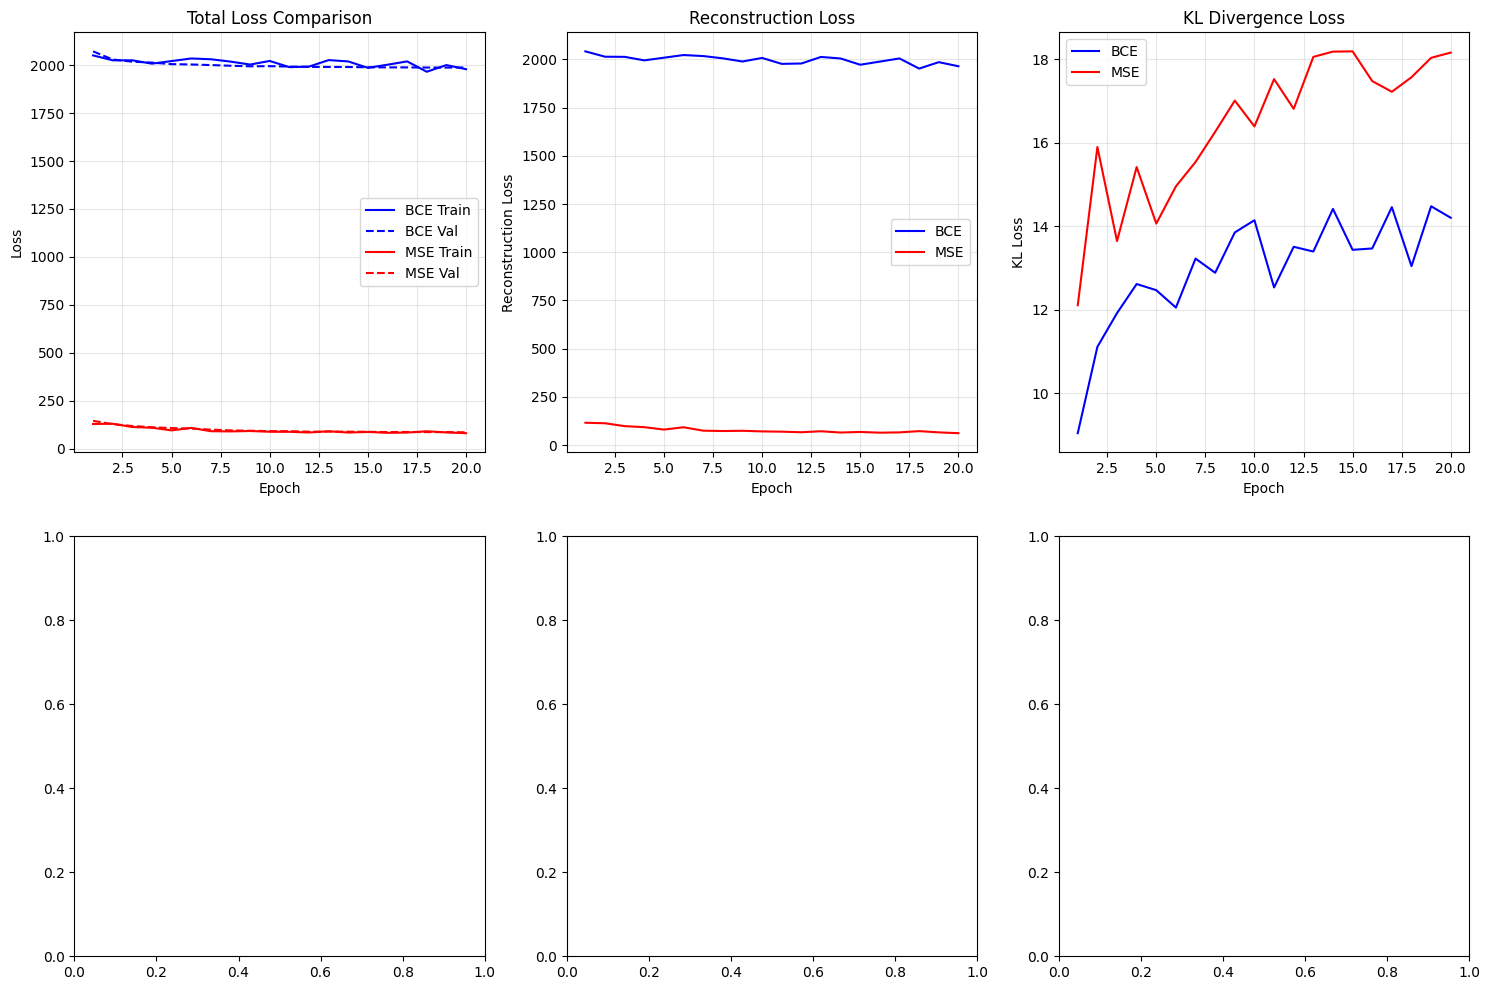

In [16]:
plot_training_comparison(bce_history, mse_history)

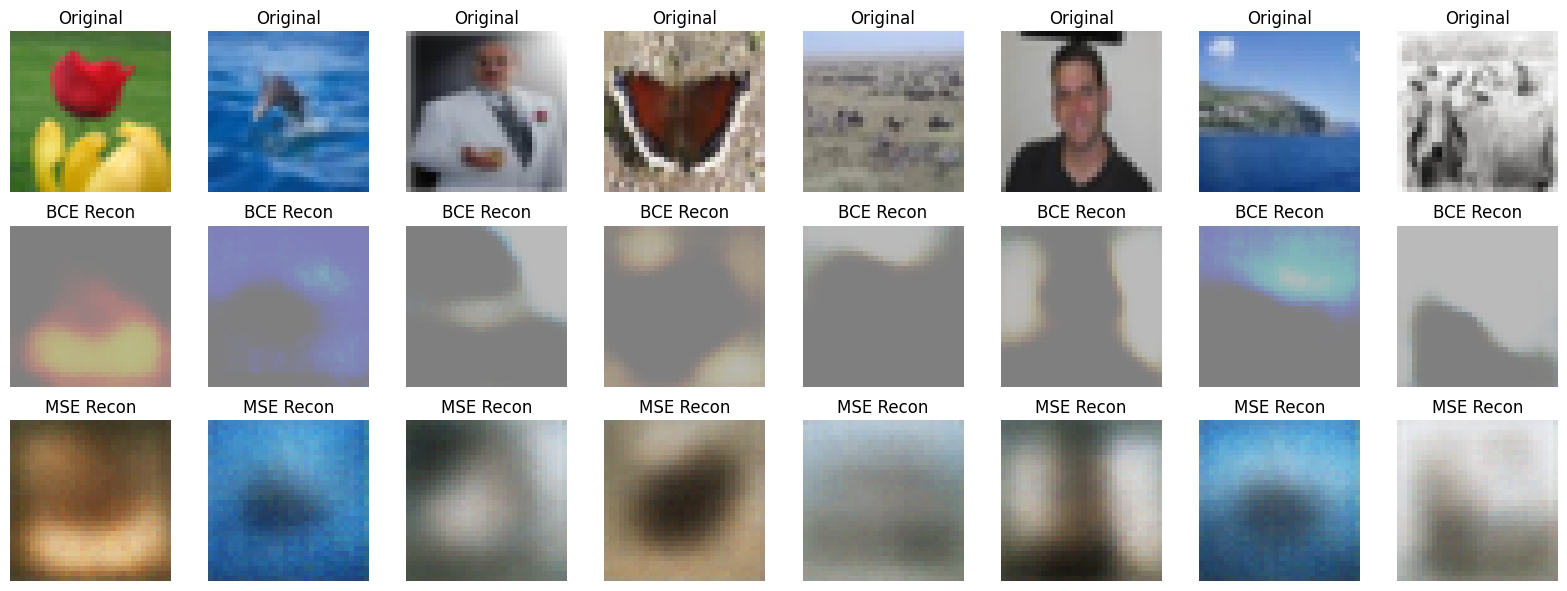

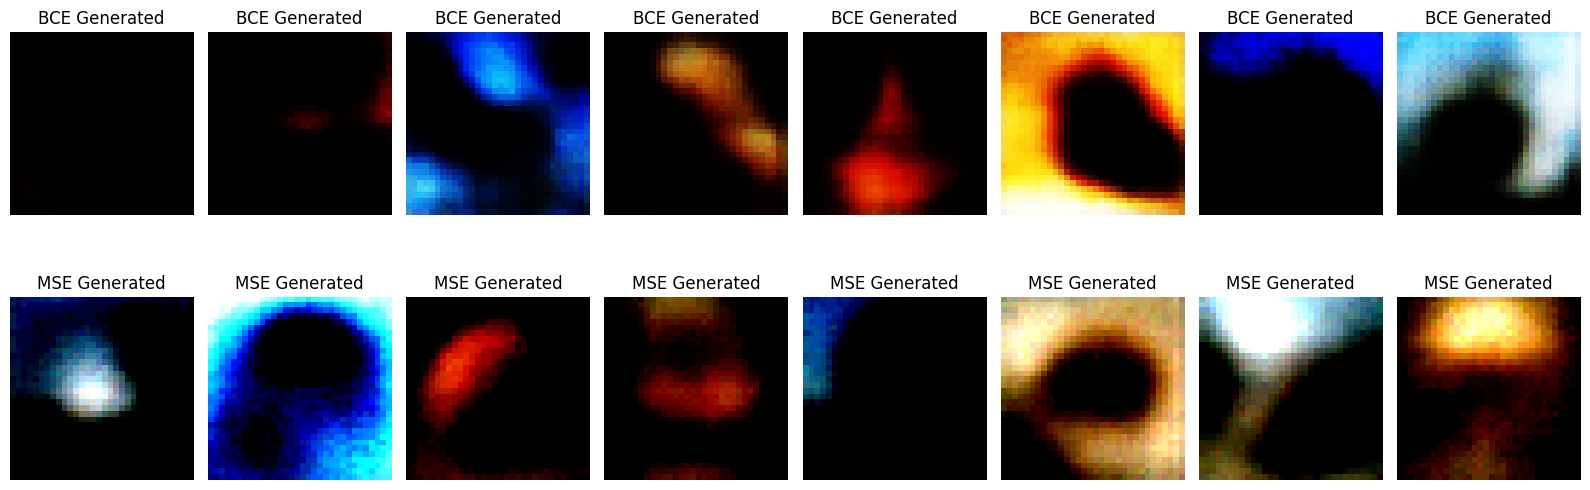

In [17]:
plot_reconstructions(vae_bce, vae_mse, x_test, num_samples=8)
plot_generated_samples(vae_bce, vae_mse, num_samples=16)

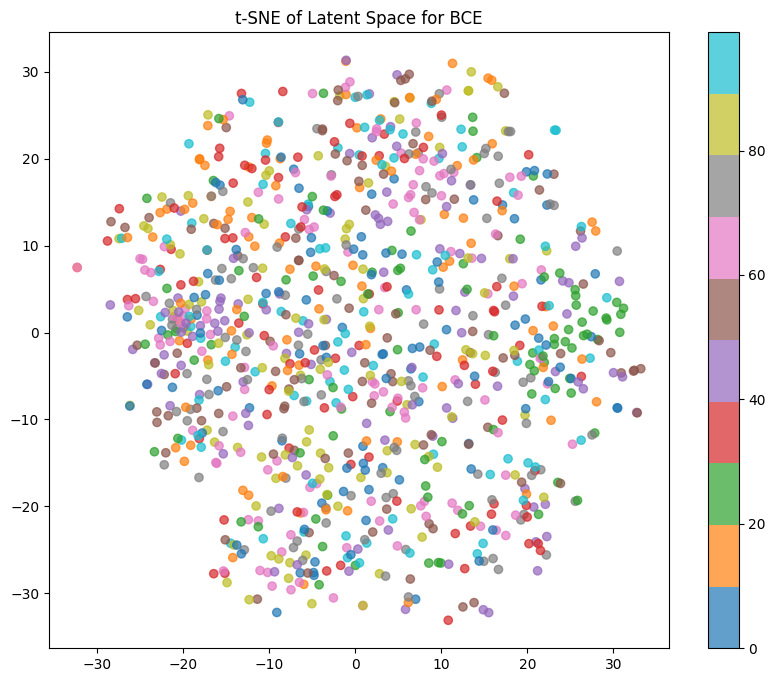

In [23]:
from sklearn.manifold import TSNE

def plot_tsne(encoder, data, labels,loss_function):
    z_mean, _ = encoder.encode(data)
    z_mean = z_mean.numpy()
    tsne = TSNE(n_components=2, perplexity=30)
    z_tsne = tsne.fit_transform(z_mean)

    plt.figure(figsize=(10, 8))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels.squeeze(), cmap="tab10", alpha=0.7)
    plt.colorbar()
    plt.title(f"t-SNE of Latent Space for {loss_function}")
    plt.show()

plot_tsne(vae_bce.vae, x_train[:1000], y_train[:1000],"BCE")


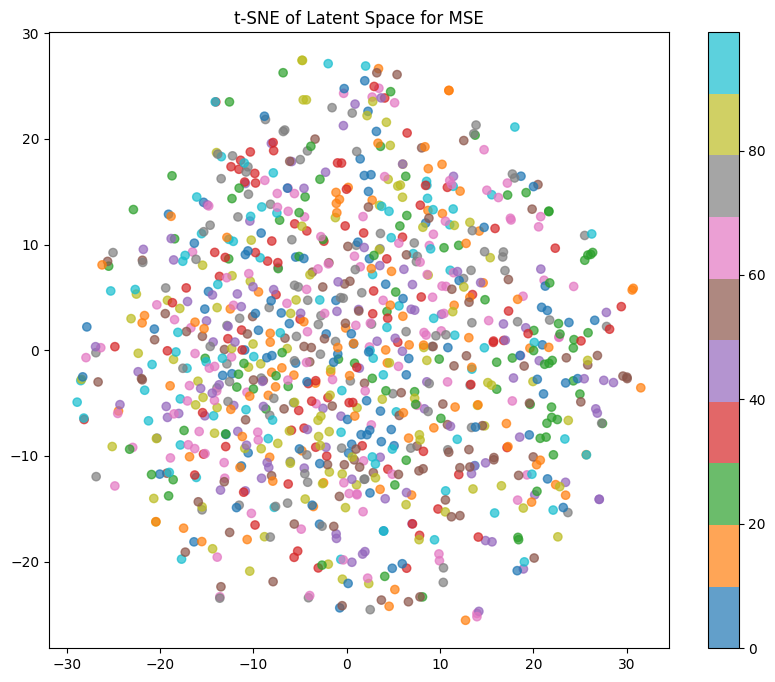

In [24]:
plot_tsne(vae_mse.vae, x_train[:1000], y_train[:1000],"MSE")